<a href="https://colab.research.google.com/github/MaartenCVonk/Causal-Modeling/blob/main/Example_of_(Conditional)_Dependencies_given_Graph_Structures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Summary**

This Notebook aims to show in what graph structures variables are dependent, independent or conditional independent. We create data according to a certain graph structure that contains a v-structure, chain and fork. Using correlation matrix, we show what variables are unconditionally dependent and then for each of these structure we show what happens when we apply conditional independence tests. Finally, we use independence algorithm (GLASSO) to extract the skeleton of the graph. Then we use a causal discovery algorithm (GES) to extract the Markov equivalence graph.

In [ ]:
!pip install dowhy &> /dev/nul
!pip install git+git://github.com/mkrphys/ipython-tikzmagic.git &> /dev/nul
!pip install cdt &> /dev/nul
!pip install CCIT==0.4 &> /dev/nul

In [ ]:
!pip install rpy2 &> /dev/nul
!sudo apt install graphviz libgraphviz-dev graphviz-dev pkg-config &> /dev/nul
!pip install pygraphviz &> /dev/nul
!pip install pydot &> /dev/nul
!pip install pyparsing==1.5.7 &> /dev/nul
!pip install GML &> /dev/nul
!pip install unidecode &> /dev/nul
!pip install dowhy &> /dev/nul
!pip install statsmodels &> /dev/nul
!pip install pickle-mixin &> /dev/nul

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


<!DOCTYPE doctype html>
<html lang="en"> <head> <meta charset="utf-8"/> <meta content="ie=edge" http-equiv="x-ua-compatible"/><link href="https://cdn.statically.io/img/htmlsave.com/images/html-save-flat.png?f=auto" rel="icon" type="image/x-icon"/> <meta content="width=device-width, initial-scale=1" name="viewport"/><meta content="noindex" name="robots"><link href="https://cdn.statically.io/gh/savehtml/static/d6fc97f6/errordocstyle.min.css" rel="stylesheet" type="text/css"/> <script src="https://cdn.statically.io/gh/savehtml/static/1ea8e3ba/poweredby.min.js" type="text/javascript"></script></meta></head> <body> <main> <figure> <a href="https://htmlsave.com" rel="dofollow"></a> </figure><title>Error Found</title><section><header><h1>Error Found <a style="color:MediumSeaGreen;">404</a></h1></header><p>The page you were looking for doesn't exist on this server.</p><ul><li><a href="javascript:location.reload();">Try reloading the page</a></li><li><a href="javascript:history.back();">Go back
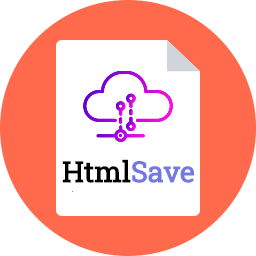

In [ ]:
import pandas as pd
import tables
import numpy as np
import scipy
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
import GPUtil
import unidecode
import joblib
import torch
import tqdm
import requests
import sklearn
import cdt #CDT depends on a number of other packages, including these R packages: https://github.com/FenTechSolutions/CausalDiscoveryToolbox/blob/master/r_requirements.txt. 
#Please see below.
from cdt.causality.graph import GES
import networkx as nx
import GML
import dowhy
from dowhy import CausalModel
import statsmodels
import statsmodels.api 
from IPython.display import Image, display
from google.colab import auth

In [ ]:
base = importr('base')
utils = importr('utils')

utils.chooseCRANmirror(ind=1)
packnames_CRAN_direct = ('devtools', 'BiocManager', 'sparsebn', 'pcalg', 'gRain', 'bnlearn') #Alternatively, 'http://www.bnlearn.com/releases/bnlearn_latest.tar.gz'
names_to_install_CRAN_direct = [x for x in packnames_CRAN_direct if not rpackages.isinstalled(x)]
if len(names_to_install_CRAN_direct) > 0:
    utils.install_packages(StrVector(names_to_install_CRAN_direct))

biocmanager = importr('BiocManager')
packnames_biocmanager = ('graph', 'RBGL', 'Rgraphviz', 'gRain')
names_to_install_biocmanager = [x for x in packnames_biocmanager if not rpackages.isinstalled(x)]
if len(names_to_install_biocmanager) > 0:
    biocmanager.install(StrVector(names_to_install_biocmanager))

devtools = importr('devtools')
packnames_github = ('cran/CAM', 'cran/D2C', 'cran/SID', 'Diviyan-Kalainathan/RCIT')
names_to_install_github = [x for x in packnames_github if not rpackages.isinstalled(x)]
if len(names_to_install_github) > 0:
    devtools.install_github(StrVector(names_to_install_github), force = True)

sparsebn = importr('sparsebn')
pcalg = importr('pcalg')
graph = importr('graph')
rbgl = importr('RBGL')
rgraphviz = importr('Rgraphviz')
#bnlearn = importr('bnlearn')
cam = importr('CAM')
d2c = importr('D2C')
sid = importr('SID')
rcit = importr('RCIT')
pcalg = importr('pcalg')

R[write to console]: Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: Warning:
R[write to console]:  dependencies ‘graph’, ‘RBGL’, ‘Rgraphviz’ are not available

R[write to console]: also installing the dependencies ‘zoo’, ‘DEoptimR’, ‘lmtest’, ‘sparsebnUtils’, ‘ccdrAlgorithm’, ‘discretecdAlgorithm’, ‘abind’, ‘igraph’, ‘ggm’, ‘corpcor’, ‘robustbase’, ‘vcd’, ‘bdsmatrix’, ‘sfsmisc’, ‘fastICA’, ‘clue’, ‘RcppArmadillo’, ‘gRbase’, ‘RcppEigen’


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/zoo_1.8-9.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 793891 bytes (775 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[

Update all/some/none? [a/s/n]: a


R[write to console]: also installing the dependencies ‘bit’, ‘bit64’, ‘vroom’, ‘tzdb’


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/bit_4.0.4.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 279723 bytes (273 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


✔  checking for file ‘/tmp/RtmpEkMyVA/remotes3e11cf0a0b/cran-CAM-fbc593d/DESCRIPTION’
─  preparing ‘CAM’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘CAM_1.0.tar.gz’
   


R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: Downloading GitHub repo cran/D2C@HEAD

R[write to console]: Skipping 3 packages not available: RBGL, Rgraphviz, graph

R[write to console]: Installing 2 packages: lazy, randomForest

R[write to console]: Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/lazy_1.2-16.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 21509 bytes (21 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]:

✔  checking for file ‘/tmp/RtmpEkMyVA/remotes3e6a35779a/cran-D2C-482b186/DESCRIPTION’
─  preparing ‘D2C’:
✔  checking DESCRIPTION meta-information
✔  checking vignette meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘D2C_1.2.1.tar.gz’
   


R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: Downloading GitHub repo cran/SID@HEAD

R[write to console]: Skipping 2 packages not available: graph, RBGL

R[write to console]: Installing 2 packages: ggm, pcalg

R[write to console]: Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/ggm_2.5.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 109414 bytes (106 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console

✔  checking for file ‘/tmp/RtmpEkMyVA/remotes3e73dc1bf3/cran-SID-9e4ab7e/DESCRIPTION’
─  preparing ‘SID’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘SID_1.0.tar.gz’
   


R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: Downloading GitHub repo Diviyan-Kalainathan/RCIT@HEAD

R[write to console]: Installing 1 packages: momentchi2

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/momentchi2_0.1.5.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 10133 bytes

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wr

✔  checking for file ‘/tmp/RtmpEkMyVA/remotes3e35570fec/Diviyan-Kalainathan-RCIT-c97f91c/DESCRIPTION’
─  preparing ‘RCIT’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
   Omitted ‘LazyData’ from DESCRIPTION
─  building ‘RCIT_0.1.0.tar.gz’
   


R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
import dowhy
import seaborn as sns
import numpy as np
import pandas as pd
import cdt 
import dowhy.api
import matplotlib.pyplot as plt
%load_ext tikzmagic
from CCIT import CCIT
import networkx as nx

In [ ]:
cdt.SETTINGS.GPU
cdt.SETTINGS.NJOBS
cdt.SETTINGS.NJOBS = 3
cdt.SETTINGS.verbose = False

## **Problem Setup:**


Suppose we have $N$ datapoints with variables $S, T, U, V$ and $Y$ that have their distributions according to the following graph structure:

Since tikz is deprecated in colab, we can't make graphs. The graph we can to depict is: $S\rightarrow T\leftarrow U \leftarrow V\rightarrow Y$





In [ ]:
N = 25000

s = np.random.uniform(size=N)
v = np.random.normal(size=N)
u = 2. * v  + 0.1 *  np.random.normal(size=N)
t = 2. * s +  3 * u + np.random.normal(size=N)

y = -2. * v  - 0.1 *  np.random.normal(size=N)
#y = np.random.binomial(1., p=1./(1. + np.exp(-5. * v)))

df = pd.DataFrame({'S': s, 'T': t, 'U': u, 'V': v, 'Y': y})


If we compare the outcomes based on Treatment without taking into account the covariates, we do it this naive way:

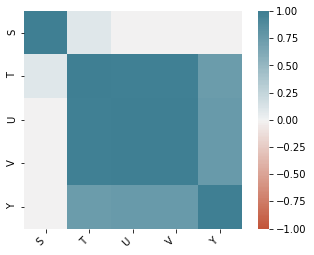

In [ ]:
#Naive effect of T on Y:
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
# In order to do conditional dependence tests we need to modify the data a bit.
nestedS=np.array([[x] for x in df['S']])
nestedT=np.array([[x] for x in df['T']])
nestedU=np.array([[x] for x in df['U']])
nestedY=np.array([[x] for x in df['Y']])
nestedV=np.array([[x] for x in df['V']])

[[0.40638922]
 [0.87331891]
 [0.84782994]
 ...
 [0.11793562]
 [0.07391214]
 [0.26251938]]


In [ ]:
#Conditional Independence testing (this is not widely available in Python so imported a CCIT package) We test dependence on the chain V->U->T
print('V and T are dependent cause p-value<0,05: ',round(CCIT.CCIT(nestedV,nestedT, Z=None),6))  
print('V and T are independent condtional U cause p-value>0,05: ', round(CCIT.CCIT(nestedV,nestedT, nestedU),6))

Reverting Back to Independence Testing
V and T are dependent cause p-value<0,05:  0.0
V and T are independent condtional U cause p-value>0,05:  0.664282


In [ ]:
#Conditional Independence testing (this is not widely available in Python so imported a CCIT package) We test dependence on the fork U<-V->TY
print('U and Y are dependent cause p-value<0,05: ',round(CCIT.CCIT(nestedU,nestedY, Z=None),6))  
print('U and Y condtional V are independent cause p-value>0,05: ', round(CCIT.CCIT(nestedU,nestedY, nestedV),6)) 

Reverting Back to Independence Testing
U and Y are dependent cause p-value<0,05:  0.0
U and Y condtional V are independent cause p-value>0,05:  0.42431


In [ ]:
#Conditional Independence testing (this is not widely available in Python so imported a CCIT package) We test dependence on the v-structure S->T<-U
print('S and U are independent cause p-value>0,05: ',round(CCIT.CCIT(nestedS,nestedU, Z=None),6))  # First test if S,U are independent. They are since p-value =>0,05
print('S and U conditional T are dependent ause p-value<0,05: ',round(CCIT.CCIT(nestedS,nestedU, nestedT),6)) # Then test if S,U are independent given T. They are not because p-value is really small.

Reverting Back to Independence Testing
S and U are independent cause p-value>0,05:  0.312844
S and U conditional T are dependent ause p-value<0,05:  1.5e-05


## **Extracting Skeleton and DAG**

Using cdt we are going to extract the skeleton of the graph and the graph to see if we indeed get the results we expect:

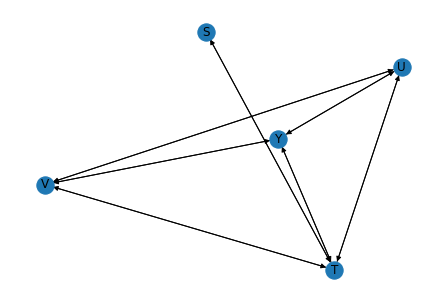

In [ ]:
#Skeleton extraction: 
glasso = cdt.independence.graph.Glasso()
skeleton = glasso.predict(df, alpha=00.1 , max_iter=8000)
nx.draw(skeleton,pos=nx.spring_layout(skeleton), with_labels=True)

# Note that there is a d-separation between every two nodes where there is no edge in between.

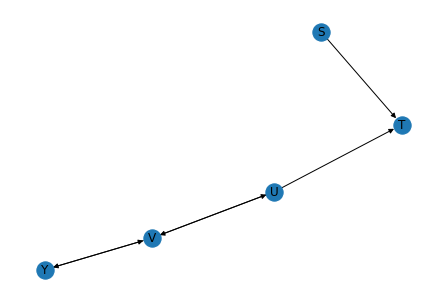

In [ ]:
#Causal Graph Extraction with Greedy Equivalence Search:
glasso = cdt.causality.graph.GES()
skeleton = glasso.predict(df)
nx.draw(skeleton,pos=nx.spring_layout(skeleton), with_labels=True)